# Submission Notebook
#### Chris Madeley

## ToC

[References](#0.-References)

1. [Statistical Test](#1.-Statistical-Test)
2. [Linear Regression](#2.-Linear-Regression) [(Questions)](#2.1-What-approach-did-you-use-to-compute-the-coefficients-theta-and-produce-prediction-for-ENTRIESn_hourly-in-your-regression-model:)
3. [Visualisation](#3.-Visualisation)
4. [Conclusion](#4.-Conclusion)
5. [Reflection](#5.-Reflection)

##Change Log
<b>Revision 1:</b> Corrections to questions 1.1, 1.4 based on the comments of the first review.

<b>Revision 2:</b> Corrections to questions 1.1, 1.4, 4.1 based on the comments of the second review.

## Overview

These answers to the assignment questions have been prepared in a Jupyter (formally IPython) notebook. This was chosen to allow clarity of working, enable reproducability, and as it should be suitable and useful for the target audience, and can be converted to html easily. In general, the code necessary for each question is included below each question, although some blocks of necessary code fall inbetween questions.

In [1]:
# Imports
# Numeric Packages
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as sps

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('talk')


# Other
from datetime import datetime, timedelta
import statsmodels.api as sm

In [2]:
# Import turnstile data and convert datetime column to datetime python objects
df = pd.read_csv('turnstile_weather_v2.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

## 0. References
In general, only standard package documentation has been used throughout. A couple of one-liners adapted from stackoverflow answers noted in code where used.

## 1. Statistical Test

#### 1.1 Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

The objective of this project, as described in the project details, is to *figure out if more people ride the subway when it is raining versus when it is not raining*.

To evaluate this question through statistical testing, a hypothesis test is used. To perform such a test two opposing hypotheses are constructed: the null hypothesis and the alternative hypothesis. A hypothesis test considers one sample of data to determine if there is sufficient evidence to reject the null hypothesis for the entire population from which it came; that the difference in the two underlying populations are different with statistical significance. The test is performed to a 'significance level' which determines the probability of Type 1 error occuring, where Type 1 error is the incorrect rejection of the null hypothesis; a false positive.


The null hypothesis is constructed to represent the status quo, where the treatment on a population has no effect on the population, chosen this way because the test controls only for Type 1 error. In the context of this assignment, the null hypothesis for this test is *on average, no more people ride the subway compared to when it is not*; i.e. 'ridership' is the population and 'rain' is the treatment.
 
i.e. $H_0: \alpha_{raining} \leq \alpha_{not\_raining}$

where $\alpha$ represents the average ridership of the subway.
 
Consequently, the alternative hypothesis is given by:

$H_1: \alpha_{raining} > \alpha_{not\_raining}$.

Due to the way the hypothesis is framed, that we are only questioning whether ridership increases during rain, a single-tailed test is required. This is because we are only looking for a test statistic that shows an increase in ridership in order to reject the null hypothesis.

A significance value of 0.05 has been chosen to reject the null hypothesis for this test, due to it being the most commonly used value for testing.

#### 1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

The Mann-Whitney U test was chosen for the hypothesis testing due as it is agnostic to the underlying distribution. The entry values are definitely not normally distributed, illustrated below both graphically and using the Shapiro-Wilk test.

Probability that data is the realisation of a gaussian random variable: 0.000


/anaconda/lib/python2.7/site-packages/scipy/stats/morestats.py:997: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


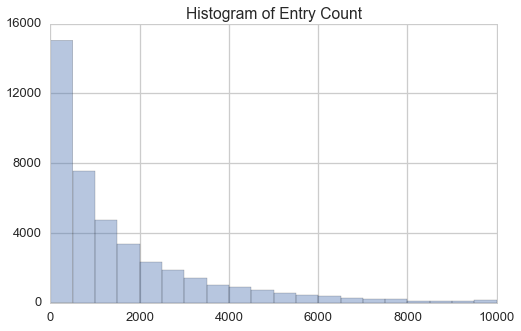

In [3]:
W, p = sps.shapiro(df.ENTRIESn_hourly.tolist())
print 'Probability that data is the realisation of a gaussian random variable: {:.3f}'.format(p)

plt.figure(figsize=[8,5])
sns.distplot(df.ENTRIESn_hourly.tolist(), bins=np.arange(0,10001,500), kde=False)
plt.xlim(0,10000)
plt.yticks(np.arange(0,16001,4000))
plt.title('Histogram of Entry Count')
plt.show()

#### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [4]:
raindata = np.array(df[df.rain==1].ENTRIESn_hourly.tolist())
noraindata = np.array(df[df.rain==0].ENTRIESn_hourly.tolist())
U, p = sps.mannwhitneyu(raindata, noraindata)
print 'Results'
print '-------'
print 'p-value:           {:.2f}'.format(p) # Note that p value calculated by scipy is single-tailed
print 'Mean with rain:    {:.0f}'.format(raindata.mean())
print 'Mean without rain: {:.0f}'.format(noraindata.mean())

Results
-------
p-value:           0.00
Mean with rain:    2028
Mean without rain: 1846


#### 1.4 What is the significance and interpretation of these results?

Given the p-value < 0.05, we can reject the null hypothesis that the average ridership is not greater when it is raining, hence the we can accept the alternative hypothesis the average ridership is greater when it rains.

## 2. Linear Regression

In [5]:
# Because the hour '0' is actually the entries from 20:00 to 24:00, it makes more sense to label it 24 when plotting data
df.datetime -= timedelta(seconds=1)
df['day']= df.datetime.apply(lambda x: x.day)
df['hour'] = df.datetime.apply(lambda x: x.hour+1)
df['weekday'] = df.datetime.apply(lambda x: not bool(x.weekday()//5))
df['day_week'] = df.datetime.apply(lambda x: x.weekday())
# The dataset includes the Memorial Day Public Holiday, which makes more sense to be classify as a weekend.
df.loc[df['day']==30,'weekday'] = False

#### 2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
Ordinary Least Squares (OLS) was used for the linear regression for this model.

#### 2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

The final fit used in the model includes multiple components, two of which include the custom input *stall_num2*, described later:
```
ENTRIESn_hourly ~ 'ENTRIESn_hourly ~ rain:C(hour) + stall_num2*C(hour) + stall_num2*weekday'
```
- `stall_num2` - includes the effect off the stall (unit) number;
- `C(hour)` - (dummy variable) included using dummy variables, since the the entries across hour vary in a highly nonlinear way;
- `weekday` - true/false value for whether it is a weekday;
- `rain:C(hour)` - rain is included as the focus of the study, however it has been combined with the time of day;
- `stall_num2 * C(hour)` - (dummy variable) interaction between the stall number and time of day; and
- `stall_num2 * weekday` - interaction between the stall number and whether it is a weekday.

Additionally, an intercept was included in the model, statsmodels appears to automatically create N-1 dummies when this is included.

The variable `stall_num2` was created as a substitute to using the `UNIT` column as a dummy variable. It was clear early on that using `UNIT` has a large impact on the model accuracy, intuitive given the relative popularity of stalls will be important for predicting their entry count. However, with 240 stalls, a lot of dummy variables are created, and it makes interactions between `UNIT` and other variables impractical. Additionally, so many dummy variables throws away information relating to the similar response between units of similar popularity.

`stall_num2` was constructed by calculating the number of entries that passed through each stall as a proportion of total entries for the entire period of the data. These results were then normalised to have μ=0 and σ=1 (although they're not normally distributed) to make the solution matrix well behaved; keep the condition number within normal bounds.

In [6]:
# Create a new column, stall_num2, representing the proportion of entries through a stall across the entire period.
total_patrons = df.ENTRIESn_hourly.sum()
# Dataframe with the units, and total passing through each unit across the time period
total_by_stall = pd.DataFrame(df.groupby('UNIT').ENTRIESn_hourly.sum())  
# Create new variable = proportion of total entries
total_by_stall['stall_num2'] = total_by_stall.ENTRIESn_hourly/total_patrons  
# Normalise by mean and standard deviation... fixes orders of magnitude errors in the output
total_stall_mean = total_by_stall.stall_num2.mean()
total_stall_stddev = total_by_stall.stall_num2.std()
total_by_stall.stall_num2 = (
                             (total_by_stall.stall_num2 - total_stall_mean)
                             / total_stall_stddev
                            )
# Map the new variable back on the original dataframe
df['stall_num2'] = df.UNIT.apply(lambda x: total_by_stall.stall_num2[x])  

#### 2.3 Why did you select these features in your model?

The first step was to qualitatively assess which parameters may be useful for the model. This begins with looking at a list of the data, and the type of data, which has been captured, illustrated as follows.

In [7]:
for i in df.columns.tolist(): print i,

UNIT DATEn TIMEn ENTRIESn EXITSn ENTRIESn_hourly EXITSn_hourly datetime hour day_week weekday station latitude longitude conds fog precipi pressurei rain tempi wspdi meanprecipi meanpressurei meantempi meanwspdi weather_lat weather_lon day stall_num2


Some parameters are going to be clearly important:
- UNIT/station - ridership will vary between entry points;
- hour - ridership will definitely be different between peak hour and 4am; and
- weekday - it is intutive that there will be more entries on weekdays; this is clearly illustrated in the visualisations in section 3.

Additionally, rain needed to be included as a feature due to it being the focus of the overall investigation.

Beyond these parameters, I selected a set of numeric features which may have an impact on the result, and initially computed and plotted the correlations between featires in an effort to screen out some multicollinearity prior linear regression. The results of this correlation matrix indicated a moderately strong correlations between:
- Entries and exits - hence exits is not really suitable for predicting entries, which is somewhat intuitive
- Day of the week and weekday - obviously correlated, hence only one should be chosen.
- Day of the month and temperature are well correlated, and when plotted show a clear warming trend throughout May.

There are also a handful of weaker environmental correlations, such as precipitation and fog, rain and precipitation and rain and temperature.

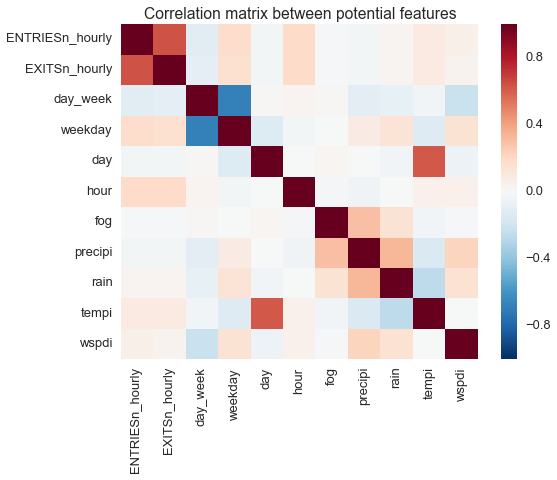

In [8]:
plt.figure(figsize=[8,6])
corr = df[['ENTRIESn_hourly',
        'EXITSn_hourly',
        'day_week',  # Day of the week (0-6)
        'weekday',   # Whether it is a weekday or not
        'day',       # Day of the month
        'hour',      # In set [4, 8, 12, 16, 20, 24]
        'fog',
        'precipi',
        'rain',
        'tempi',
        'wspdi']].corr()
sns.heatmap(corr)
plt.title('Correlation matrix between potential features')
plt.show()

The final selection of variables was determined through trial and error of rational combinations of variables. The station popularity was captured in using the `stall_num2` variable, since it appears to create a superior model compared with just using UNIT dummies, and because it allowed the creation of combinations. Combining the station with hour was useful, and is intuitive since stations in the CBD will have the greatest patronage and have greater entries in the evening peak hour. A similar logic applies to combining the station and whether it is a weekday.

Various combinations of environmental variables were trialled in the model, but none appeared to improve the model accuracy and were subsequently dicarded. Since rain is the focus of this study it was retained, however it was combined with the time of day. The predictive strenght of the model was not really improved with the inclusion of a rain parameter, however combining it with `hour` appears to improve it's usefulness for providing insight, as will be discussed in section 4.

#### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

In [9]:
# Construct and fit the model
mod = sm.OLS.from_formula('ENTRIESn_hourly ~ rain:C(hour) + stall_num2*C(hour) + stall_num2*weekday', data=df)
res = mod.fit_regularized()
s = res.summary2()

Due to the use of several combinations, there are very few non-dummy features, with the coefficients illustrated below. Since `stall_num2` is also used in several combinations, it's individual coefficient doesn't prove very useful. 

In [10]:
s.tables[1].ix[['Intercept', 'stall_num2']]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-401.449568,22.341075,-17.969125,6.271412e-72,-445.238513,-357.660622
stall_num2,-393.720700,20.434704,-19.267258,2.269039e-82,-433.773120,-353.668279


However when looking at all the combinations for stall_num2 provides greater insight. Here we can see that activity is greater on weekdays, and greatest in the 16:00-20:00hrs block. It is lowest in the 00:00-04:00hrs block, not shown as it was removed by the model due to the generic `stall_num2` parameter being there; the other combinations are effectively referenced to the 00:00-04:00hrs block.

In [11]:
s.tables[1].ix[[i for i in s.tables[1].index if i[:5]=='stall']]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
stall_num2,-393.720700,20.434704,-19.267258,2.269039e-82,-433.773120,-353.668279
stall_num2:C(hour)[T.8],224.264507,25.485147,8.799812,1.420727e-18,174.313118,274.215896
stall_num2:C(hour)[T.12],1775.196969,24.853015,71.427832,0.000000e+00,1726.484572,1823.909366
stall_num2:C(hour)[T.16],1849.274264,24.863000,74.378566,0.000000e+00,1800.542296,1898.006232
stall_num2:C(hour)[T.20],3492.552254,24.848954,140.551281,0.000000e+00,3443.847817,3541.256691
stall_num2:C(hour)[T.24],1337.634208,24.843562,53.842287,0.000000e+00,1288.940338,1386.328077
stall_num2:weekday[T.True],1098.123503,15.422163,71.204249,0.000000e+00,1067.895761,1128.351244


Even more interesting are the coefficient for the rain combinations. These appear to indicate that patronage increases in the 08:00-12:00 and 16:00-20:00, corresponding to peak hour. Conversely, subway entries are lower at all other times. Could it be that subway usage increases if it is raining when people are travelling to and from work, but decreases otherwise because people prefer not to travel in the rain at all?

In [12]:
s.tables[1].ix[[i for i in s.tables[1].index if i[:4]=='rain']]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
rain:C(hour)[4],-217.279031,42.233960,-5.144652,2.692023e-07,-300.058422,-134.499639
rain:C(hour)[8],-109.748862,46.493100,-2.360541,1.825279e-02,-200.876252,-18.621472
rain:C(hour)[12],222.370285,42.336147,5.252492,1.507739e-07,139.390604,305.349965
rain:C(hour)[16],-126.753986,42.440842,-2.986604,2.822552e-03,-209.938869,-43.569103
rain:C(hour)[20],192.925509,42.393890,4.550786,5.359330e-06,109.832652,276.018366
rain:C(hour)[24],-64.415834,42.224034,-1.525573,1.271237e-01,-147.175769,18.344102


#### 2.5 What is your model’s R2 (coefficients of determination) value?

In [13]:
print 'Model Coefficient of Determination (R-squared): {:.3f}'.format(res.rsquared)

Model Coefficient of Determination (R-squared): 0.739


The final R-squared value of 0.74 is much greater than earlier models that used `UNIT` as a dummy variable, which had R-squared values around 0.55.

#### 2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

To evaluate the goodness of fit the residuals of the model have been evaluated in two ways. First, a histogram of the residuals has been plotted below. The distribution of residuals is encouragingly symmetric. However efforts to fit a normal distribution found distributions which underestimated the frequency at the mode and tails. Fitting a fat-tailed distribution, such as the Cauchy distribution below, was far more successful. I'm not sure if there's a good reason why it's worked out this way (but would love to hear ideas as to why).

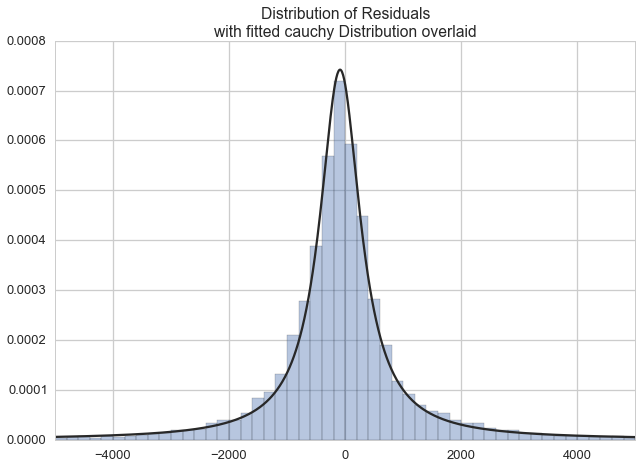

In [14]:
residuals = res.resid
sns.set_style('whitegrid')
sns.distplot(residuals,bins=np.arange(-10000,10001,200),
            kde = False, # kde_kws={'kernel':'gau', 'gridsize':4000, 'bw':100},
            fit=sps.cauchy, fit_kws={'gridsize':4000})
plt.xlim(-5000,5000)
plt.title('Distribution of Residuals\nwith fitted cauchy Distribution overlaid')
plt.show()

Secondly, a scatterplot of the residuals against the expected values is plotted. As expected, the largest residuals are associated with cases where the traffic is largest. In general the model appears to underpredict the traffic at the busiest of units. Also clear on this plot is how individual stations form a 'streak' of points on the diagonal. This is because the model essentially makes a prediction for each station per hour per for weekdays and weekends. The natural variation of the actual result in this timeframe creates the run of points.

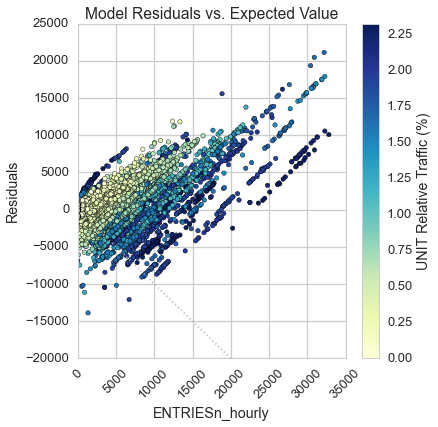

In [15]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=[6,6])
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Residuals')
plt.scatter(df.ENTRIESn_hourly, residuals,
            c=(df.stall_num2*total_stall_stddev+total_stall_mean)*100, # denormalise values
            cmap='YlGnBu')
plt.colorbar(label='UNIT Relative Traffic (%)')
plt.plot([0,20000],[0,-20000], ls=':', c='0.7', lw=2) # Line to show negative prediction values (i.e. negative entries)
plt.xlim(xmin=0)
plt.ylim(-20000,25000)
plt.xticks(rotation='45')
plt.title('Model Residuals vs. Expected Value')
plt.show()

Additionally, note that the condition number for the final model is relatively low, hence there don't appear to be any collinearity issues with this model. By comparison, when UNIT was included as a dummy variable instead, the correlation was weaker and the condition number was up around 220.

In [16]:
print 'Condition Number: {:.2f}'.format(res.condition_number)

Condition Number: 10.55


In summary, it appears that this linear model has done a reasonable job of predicting ridership in this instance. Clearly some improvements are possible (like fixing the predictions of negative entries!), but given there will always be a degree of random variation, an R-squared value of 0.74 for a linear model seems quite reasonable. To be sure of the model suitability the data should be split into training/test sets. Additionally, more data from extra months could prove beneficial.

## 3. Visualisation

#### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

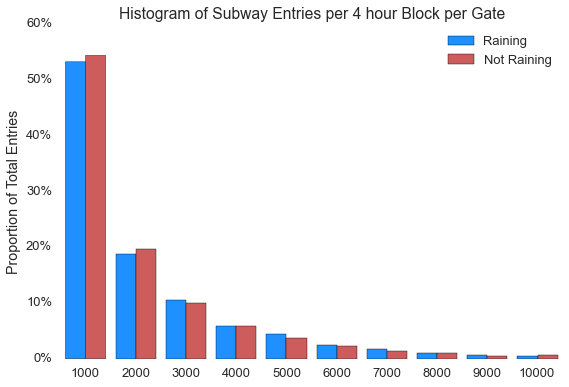

In [17]:
sns.set_style('white')
sns.set_context('talk')
mydf = df.copy()
mydf['rain'] = mydf.rain.apply(lambda x: 'Raining' if x else 'Not Raining')
raindata = df[df.rain==1].ENTRIESn_hourly.tolist()
noraindata = df[df.rain==0].ENTRIESn_hourly.tolist()

fig = plt.figure(figsize=[9,6])
ax = fig.add_subplot(111)
plt.hist([raindata,noraindata],
         normed=True,
         bins=np.arange(0,11500,1000),
         color=['dodgerblue', 'indianred'],
         label=['Raining', 'Not Raining'],
         align='right')
plt.legend()
sns.despine(left=True, bottom=True)


# http://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
def adjust_y_axis(x, pos):
    return '{:.0%}'.format(x * 1000)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(adjust_y_axis))
plt.title('Histogram of Subway Entries per 4 hour Block per Gate')
plt.ylabel('Proportion of Total Entries')
plt.xlim(500,10500)
plt.xticks(np.arange(1000,10001,1000))
plt.show()

Once both plots are normalised, the difference between subway entries when raining and not raining are almost identical. No useful differentiation can be made between the two datasets here.

#### 3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. 

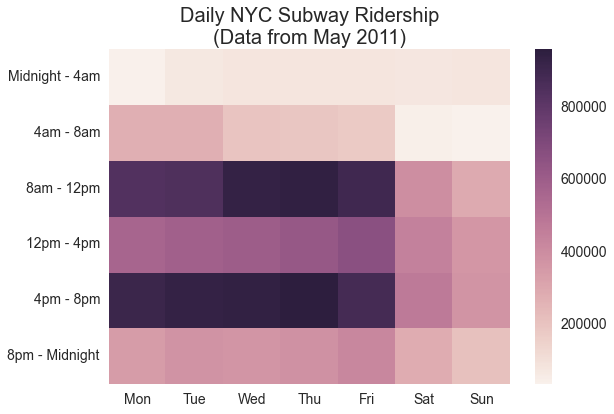

In [18]:
# Plot to illustrate the average riders per time block for each weekday.
# First we need to sum up the entries per hour (category) per weekday across all units.
# This is done for every day, whilst retaining the 'day_week' field for convenience. reset_index puts it back into a standard dataframe
# For the sake of illustration, memorial day has been excluded since it would incorrectly characterise the Monday ridership
mydf = df.copy()
mydf = mydf[mydf.day!=30].pivot_table(values='ENTRIESn_hourly', index=['day','day_week','hour'], aggfunc=np.sum).reset_index()
# The second pivot takes the daily summed data, and finds the mean for each weekday/hour block.
mydf = mydf.pivot_table(values='ENTRIESn_hourly', index='hour', columns='day_week', aggfunc=np.mean)

# Generate plout using the seaborn heatplot function.
fig = plt.figure(figsize=[9,6])
timelabels = ['Midnight - 4am','4am - 8am','8am - 12pm','12pm - 4pm','4pm - 8pm','8pm - Midnight']
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot = sns.heatmap(mydf, yticklabels=timelabels, xticklabels=weekdays)
plt.xlabel('') # The axis ticks are descriptive enough to negate the need for axis labels
plt.ylabel('')
plot.tick_params(labelsize=14) # Make stuff bigger!

# Make heatmap ticks bigger http://stackoverflow.com/questions/27832054/change-tick-size-on-colorbar-of-seaborn-heatmap
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=14)

plt.title('Daily NYC Subway Ridership\n(Data from May 2011)', fontsize=20)
plt.show()

This plot illustrates the variation in ridership of the subway across the week. Ridership is very small in the very early morning, and there are two bold stripes where peak hour occurs in at 8am-12pm and 4pm-8pm. The weekend is clearly far less busy, in fact the 4am-8am block is the quietest of the day!

## 4. Conclusion

#### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining? 
The statistical test performed in section 1 indicates that on average, more people ride the subway when it is raining. However the relationship between rain and ridership are possibly more complex, the results described in section 2.4 indicate that the impact of rain on ridership may depend on time of day, with more people using the subway when it rains during peak hour, and fewer otherwise.

#### 4.2 What analyses lead you to this conclusion?
The statistical tests do indicate that on average ridership is greater when it rains. However, the difference in mean is small. When linear regression was used, the effect of rain can be considered with other variables controlled for. When rain was considered without considering the interaction with time of day, there was no statistically significant result for the effect of rain. Controlling for time of day indicates the more detailed result described previously. Although the p-values for each of the coefficients described previously are small, indicating statistical significance, the effect of rain is a second-order effect on patronage. In fact, the addition of rain, with time of day interaction, didn't improve the accuracy of the model by an appreciable amount; if it wasn't the focus of this study the variable would have been dropped.


## 5. Reflection

#### 5.1 Please discuss potential shortcomings of the methods of your analysis, including: 1. Dataset, 2. Analysis, such as the linear regression model or statistical test.
The dataset was too short in duration, and therefor had too few rainy days, to draw detailed conclusions. Given this is publicly available data, and once the effort to wrangle the data had been made, it would probably be sensible to run the analyses on far larger timespans. Of course, running the analysis over many months would require adding variables to control for seasons/time of year.

The linear regression model worked better than expected, finishing with an r-squared value of 0.74. However it has curious features, such as predicting negative entries for some cases, which is clearly impossible. I imagine there are superior approaches to modelling the system, however this model can't be too far off the ultimate achievable accuracy, the natural daily variation can't be captured in any (reasonable model). For instance, when the Yankees play the nearest station will have a great increase in patronage, but that won't be captured in any model which doesn't include the playing schedule of the team, which applies to all other large events around NYC.

One aspect of using a correctly constructed linear model is the simplicity of understanding the relative effect of each parameter, since each one is described by a single coefficient. More complex models may not provide the same level of simple insight that comparing coefficients can provide.

#### 5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

This is more to do with the linear model than the dataset: I tried eliminating the negative predictions by fitting the model square-root of the entries, and then squaring the output predictions. This was successful in eliminating the negative predictions, and only reduced the predictive capactiy from an R-squared value of 0.74 to approx 0.71. Although this is one approach to eliminating the negative values (which didn't sit well with me, and which I wouldn't want to include in any published model as it would be ridiculed by the public), I'm curious to know if there are any better approaches to keeping the predictions positive.